In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import ArxivLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

In [38]:
### load llm models
import os
from langchain.chat_models import init_chat_model
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=init_chat_model("groq:openai/gpt-oss-120b")

In [40]:
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [4]:
def load_text_retriever(file_path):
    docs = TextLoader(file_path, encoding="utf-8").load()
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    chunks = splitter.split_documents(docs)
    vs = FAISS.from_documents(chunks, embeddings)
    return vs.as_retriever()

In [33]:
def load_youtube_retriever():
    # Dummy YouTube transcript text
    content = """
    This video explains how agentic AI systems rely on feedback loops, memory, and tool use.
    It compares them to traditional pipeline-based LLMs. Temporal reasoning and autonomous tasking are emphasized.
    """
    doc = Document(page_content=content, metadata={"source": "youtube"})
    vectorstore = FAISS.from_documents([doc],embeddings)
    return vectorstore.as_retriever()



def wikipedia_search(query: str) -> str:
    print(" Searching Wikipedia...")
    api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
    wikipedia=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)    
    return  wikipedia.invoke(query)

def arxiv_search(query: str) -> str:
    print(" Searching ArXiv...")
    response_from_llm = llm.invoke(f"""Extract 5 concise academic search keywords from this question.
Return only keywords. Just that nothing extra {query}
""")
    print(response_from_llm)
    results = ArxivLoader(response_from_llm.content).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found."

In [24]:
response_wiki = wikipedia_search(query="who is stephen hawking")
response_wiki

 Searching Wikipedia...


'Page: Stephen Hawking\nSummary: Stephen William Hawking (8 January 1942 – 14 March 2018) was an English theoretical astrophysicist, cosmologist, and author who was director of research at the Centre for Theoretical Cosmology at the University of Cambridge. Between 1979 and 2009, he was the Lucasian Professor of Mathematics at Cambridge, widely viewed as one of the most prestigious academic posts in the world.\nHawking was born in Oxford into a family of physicians. In 1959, at the age of 17, he be'

In [27]:
response_arxiv = arxiv_search(query= "who is stephen hawking")
response_arxiv

 Searching ArXiv...


'arXiv:math/9806022v2  [math.PR]  3 Dec 1999\nE l e c t r o n i c\nJ\no\nu r n a l\no\nf\nP r o b a b i l i t y\nhttp://www.math.washington.edu/~ejpecp/\nConcrete Representation of Martingales\nStephen Montgomery-Smith\nDepartment of Mathematics\nUniversity of Missouri, Columbia, MO 65211\nstephen@math.missouri.edu\nhttp://math.missouri.edu/~stephen\nVolume 3, paper number 15, 1998\nhttp://www.math.washington.edu/~ejpecp/EjpVol3/paper15.abs.html\n15 pages, submitted June 4, 1998, published December 2, 1998\nAbstract: Let (fn) be a mean zero vector valued martingale sequence. Then there exist\nvector valued functions (dn) from [0, 1]n such that\nR 1\n0 dn(x1, . . ., xn) dxn = 0 for almost all\nx1, . . ., xn−1, and such that the law of (fn) is the same as the law of (Pn\nk=1 dk(x1, . . . , xk)).\nSimilar results for tangent sequences and sequences satisfying condition (C.I.) are pre-\nsented. We also present a weaker version of a result of McConnell that provides a Skorohod\nlike represe

In [8]:
text_retriever = load_text_retriever("research-notes.txt")
youtube_retriever = load_youtube_retriever()

In [9]:
### state
class MultiSourceRAGState(BaseModel):
    question: str
    text_docs: List[Document] = []
    yt_docs: List[Document] = []
    wiki_context: str = ""
    arxiv_context: str = ""
    final_answer: str = ""

In [10]:
### Retrieval Nodes
def retrieve_text(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = text_retriever.invoke(state.question)
    return state.model_copy(update={"text_docs": docs})

def retrieve_yt(state: MultiSourceRAGState) -> MultiSourceRAGState:
    docs = youtube_retriever.invoke(state.question)
    return state.model_copy(update={"yt_docs": docs})

def retrieve_wikipedia(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = wikipedia_search(state.question)
    return state.model_copy(update={"wiki_context": result})

def retrieve_arxiv(state: MultiSourceRAGState) -> MultiSourceRAGState:
    result = arxiv_search(state.question)
    return state.model_copy(update={"arxiv_context": result})

In [44]:
summarizer_llm = init_chat_model(
    model="groq:openai/gpt-oss-20b",
    temperature=0
)


In [45]:
def safe_slice(text: str, max_chars: int = 3000) -> str:
    return text[:max_chars]


In [46]:
def compress_context(summarizer_llm, text: str, source: str) -> str:
    sliced = safe_slice(text)
    prompt = f"""
Summarize the following {source} content in 5 bullet points.
Focus only on facts relevant to the question.

{sliced}
"""
    return llm.invoke(prompt).content.strip()


## synthesize
def synthesize_answer(state: MultiSourceRAGState) -> MultiSourceRAGState:
    
    context = ""

    context += "\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context += "\n\n[YouTube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    from_wiki_to_llm = compress_context(summarizer_llm,state.wiki_context,"wikipedia")
    from_axiv_to_llm = compress_context(summarizer_llm,state.arxiv_context,"arxiv")
    context += "\n\n[Wikipedia]\n" + from_wiki_to_llm
    context += "\n\n[ArXiv]\n" + from_axiv_to_llm

    prompt = f"""You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.

Question: {state.question}

Context:
{context}

Final Answer:"""

    answer = llm.invoke(prompt).content.strip()
    return state.model_copy(update={"final_answer": answer})

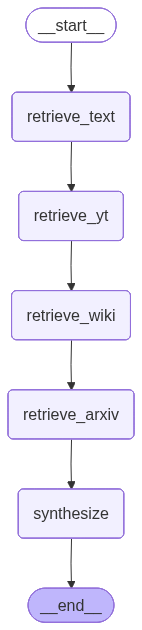

In [47]:
builder = StateGraph(MultiSourceRAGState)

builder.add_node("retrieve_text", retrieve_text)
builder.add_node("retrieve_yt", retrieve_yt)
builder.add_node("retrieve_wiki", retrieve_wikipedia)
builder.add_node("retrieve_arxiv", retrieve_arxiv)
builder.add_node("synthesize", synthesize_answer)

builder.set_entry_point("retrieve_text")
builder.add_edge("retrieve_text", "retrieve_yt")
builder.add_edge("retrieve_yt", "retrieve_wiki")
builder.add_edge("retrieve_wiki", "retrieve_arxiv")
builder.add_edge("retrieve_arxiv", "synthesize")
builder.add_edge("synthesize", END)

graph = builder.compile()
graph

In [48]:
question = "What is LoRa tuning and how does it reduce GPU memory usage ?"
state = MultiSourceRAGState(question=question)
result = graph.invoke(state)

print(" Final Answer:\n")
print(result["final_answer"])

 Searching Wikipedia...
 Searching ArXiv...
content='LoRA tuning  \nGPU memory optimization  \nparameter-efficient fine-tuning  \nlow-rank adaptation  \nmemory reduction techniques' additional_kwargs={'reasoning_content': 'The user asks: "Extract 5 concise academic search keywords from this question. Return only keywords. Just that nothing extra What is LoRa tuning and how does it reduce GPU memory usage ?" So we need to produce 5 keywords, concise, academic style, related to LoRa tuning and GPU memory usage. Likely keywords: "LoRA tuning", "GPU memory optimization", "parameter-efficient fine-tuning", "low-rank adaptation", "memory reduction techniques". Must return only keywords, separated perhaps by commas or new lines? They said "Return only keywords. Just that nothing extra". So we can output each keyword on a separate line, or comma-separated. Probably newline separated is fine. Provide exactly 5 keywords. No extra text. Let\'s do newline separated.'} response_metadata={'token_usa